 Get data from scholia to visualize as hive plot: all related diseases of schizophrenia


In [1]:
import SPARQLWrapper

sparql = SPARQLWrapper.SPARQLWrapper("https://query.wikidata.org/sparql")

query = '''
PREFIX target: <http://www.wikidata.org/entity/Q41112>

SELECT
  ?count
  ?gene_count
  ?symptom_count
  ?disease ?diseaseLabel
  ?genes
  ?symptoms
{
  {
    SELECT ?disease (COUNT(?gene) AS ?gene_count) (GROUP_CONCAT(?gene_label; separator=" // ") AS ?genes) WHERE {
      target: wdt:P2293 ?gene .
      ?gene wdt:P2293 ?disease .
      FILTER (target: != ?disease)
      ?gene rdfs:label ?gene_label
      FILTER(lang(?gene_label) = "en")
    }
    GROUP BY ?disease
  }
  UNION
  {
    SELECT
      ?disease (COUNT(?symptom) AS ?symptom_count) (GROUP_CONCAT(?symptom_label; separator=" // ") AS ?symptoms)
    {
      target: wdt:P780 ?symptom .
      ?disease wdt:P780 ?symptom .
      FILTER (target: != ?disease)
      ?symptom rdfs:label ?symptom_label . FILTER(lang(?symptom_label) = "en")
    }
    GROUP BY ?disease
  }

  # Aggregate count
  BIND((COALESCE(?symptom_count, 0) + COALESCE(?gene_count, 0)) AS ?count)

  SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
}
ORDER BY DESC(?count)
'''

# Set the query language to SPARQL
sparql.setQuery(query)

# Set the return format to JSON
sparql.setReturnFormat(SPARQLWrapper.JSON)

# Execute the query and store the results
results = sparql.query().convert()


In [2]:
for disease in results['results']['bindings']:
    for key, value in disease.items():
        print(key)
        print(value['value'])

disease
http://www.wikidata.org/entity/Q131755
diseaseLabel
bipolar disorder
count
14
gene_count
14
genes
NPAS3 // CACNA1C // PTPRN2 // IFT88 // KCNMB2 // ANK3 // MSRA // RIN2 // PHF8 // CNTNAP2 // ERC2 // COMMD10 // NLRC5 // MYO18B
disease
http://www.wikidata.org/entity/Q12174
diseaseLabel
obesity
count
5
gene_count
5
genes
PTPRN2 // RIN2 // CSMD1 // CNTNAP2 // CTNNA3
disease
http://www.wikidata.org/entity/Q4340209
diseaseLabel
mental depression
count
5
gene_count
5
genes
NPAS3 // CDH13 // IFT88 // MYO18B // RORA
disease
http://www.wikidata.org/entity/Q11081
diseaseLabel
Alzheimer's disease
count
5
gene_count
5
genes
RELN // CACNA1G // CSMD1 // CNTNAP2 // NKAIN2
disease
http://www.wikidata.org/entity/Q520127
diseaseLabel
periodontitis
count
4
gene_count
4
genes
CDH13 // CSMD1 // ERC2 // NKAIN2
disease
http://www.wikidata.org/entity/Q35869
diseaseLabel
asthma
count
3
gene_count
3
genes
NOTCH4 // CTNNA3 // RORA
disease
http://www.wikidata.org/entity/Q42844
diseaseLabel
major depressive 

In [3]:
reformatted_dict = {}

entities = []
result_list = results['results']['bindings']
for res in result_list:
    for res_key, res_value in res.items():
        if res_key == 'disease':
            uri = res_value['value']
            splitted_uri = uri.split('/')
            entity_id = splitted_uri[-1]
            entities.append(entity_id)
            reformatted_dict[entity_id] = res

print(reformatted_dict)

{'Q131755': {'disease': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q131755'}, 'diseaseLabel': {'xml:lang': 'en', 'type': 'literal', 'value': 'bipolar disorder'}, 'count': {'datatype': 'http://www.w3.org/2001/XMLSchema#integer', 'type': 'literal', 'value': '14'}, 'gene_count': {'datatype': 'http://www.w3.org/2001/XMLSchema#integer', 'type': 'literal', 'value': '14'}, 'genes': {'type': 'literal', 'value': 'NPAS3 // CACNA1C // PTPRN2 // IFT88 // KCNMB2 // ANK3 // MSRA // RIN2 // PHF8 // CNTNAP2 // ERC2 // COMMD10 // NLRC5 // MYO18B'}}, 'Q12174': {'disease': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q12174'}, 'diseaseLabel': {'xml:lang': 'en', 'type': 'literal', 'value': 'obesity'}, 'count': {'datatype': 'http://www.w3.org/2001/XMLSchema#integer', 'type': 'literal', 'value': '5'}, 'gene_count': {'datatype': 'http://www.w3.org/2001/XMLSchema#integer', 'type': 'literal', 'value': '5'}, 'genes': {'type': 'literal', 'value': 'PTPRN2 // RIN2 // CSMD1 // CNTNAP2 // C

In [4]:
import pandas as pd

df = pd.DataFrame.from_dict(reformatted_dict)
df = df.transpose()

for index, row in df.iterrows():
    print(row)

print(df)

disease          {'type': 'uri', 'value': 'http://www.wikidata....
diseaseLabel     {'xml:lang': 'en', 'type': 'literal', 'value':...
count            {'datatype': 'http://www.w3.org/2001/XMLSchema...
gene_count       {'datatype': 'http://www.w3.org/2001/XMLSchema...
genes            {'type': 'literal', 'value': 'NPAS3 // CACNA1C...
symptom_count                                                  NaN
symptoms                                                       NaN
Name: Q131755, dtype: object
disease          {'type': 'uri', 'value': 'http://www.wikidata....
diseaseLabel     {'xml:lang': 'en', 'type': 'literal', 'value':...
count            {'datatype': 'http://www.w3.org/2001/XMLSchema...
gene_count       {'datatype': 'http://www.w3.org/2001/XMLSchema...
genes            {'type': 'literal', 'value': 'PTPRN2 // RIN2 /...
symptom_count                                                  NaN
symptoms                                                       NaN
Name: Q12174, dtype: object
disea

In [8]:
from hiveplotlib import hive_plot_n_axes
from hiveplotlib.converters import networkx_to_nodes_edges
from hiveplotlib.viz import hive_plot_viz
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

rng = np.random.default_rng(0)

# 3 "clusters"
num_clusters = len(df.index)

# edges within each cluster
num_edges_per_cluster = [30, 60, 90]

# edges between any nodes
num_misc_edges = 20

# number of points in each cluster
pts_per_cluster = 50

# build nodes and edges
node_ids = []
edges = []

# also track the "true" group assignment
group = []
for i, num_edges in zip(range(num_clusters), num_edges_per_cluster):
    within_node_ids = list(np.arange(pts_per_cluster) + (i * pts_per_cluster))
    node_ids += within_node_ids
    edges.append(rng.choice(within_node_ids, size=num_edges*2).reshape(-1, 2))
    group += [i] * pts_per_cluster

# add some miscellaneous connections between any of the edges
edges.append(rng.choice(node_ids, size=num_misc_edges*2).reshape(-1, 2))

edges = np.row_stack(edges)

# put into networkx format for networkx viz
G = nx.Graph()
G.add_nodes_from(node_ids)
G.add_edges_from(list(edges))

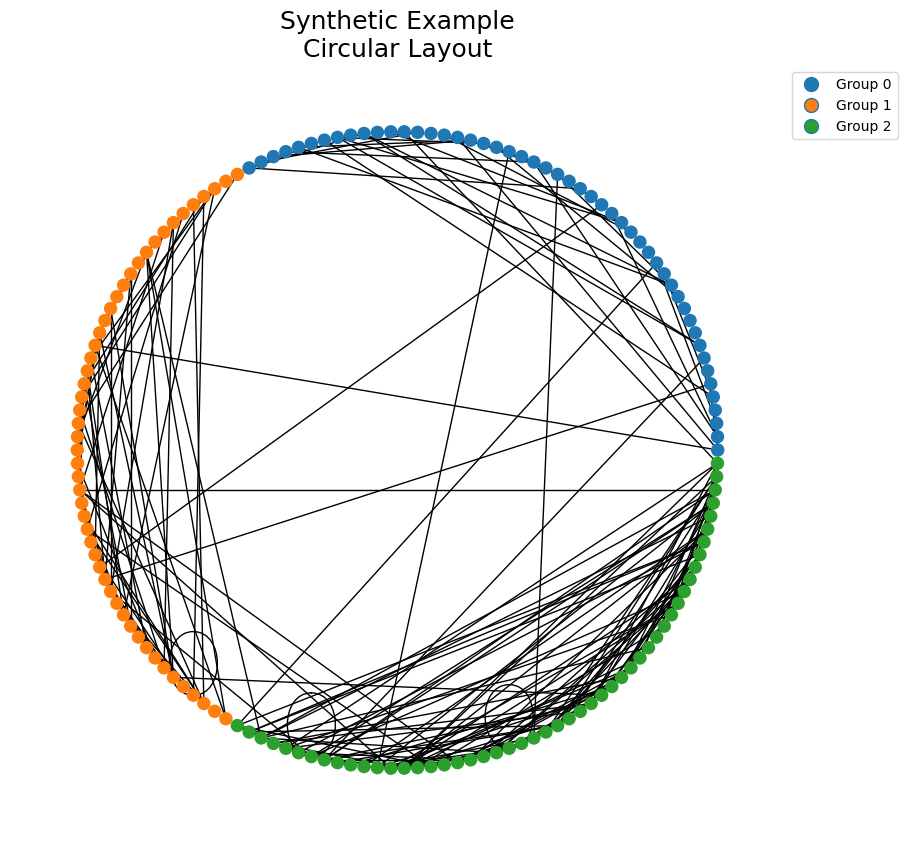

In [9]:
fig, ax = plt.subplots(figsize=(10, 10))
pos = nx.circular_layout(G)
colors = [f"C{i}" for i in group]
nx.draw_networkx_nodes(G, pos, ax=ax, node_color=colors, node_size=75)
nx.draw_networkx_edges(G, pos, ax=ax, edge_color="black")

# legend
custom_lines = [Line2D([0], [0], markerfacecolor=f'C{i}',
                       marker='o', linestyle='None', markersize=10)
                for i in range(num_clusters)]
custom_labels = [f"Group {i}" for i in range(num_clusters)]

ax.legend(custom_lines, custom_labels,
          loc='upper left', bbox_to_anchor=(1, 1))

ax.set_title("Synthetic Example\nCircular Layout", fontsize=18)
ax.axis("off")

plt.show()

In [5]:
import matplotlib.pyplot as plt
import hiveplot as hv

# Defining the hiveplot layout
layout = hv.HivePlotLayout()

# Adding nodes to the layout
disease_node = layout.add_node('Disease')
gene_node = layout.add_node('Gene')

# Adding links between nodes
for i, row in df.iterrows():
    layout.add_edge(disease_node, gene_node, row['Disease']['value'], row['Gene']['value'])

# Drawing the hiveplot
fig, ax = plt.subplots(figsize=(8,8))
layout.draw(ax=ax)

# Displaying the hiveplot
plt.show()



AttributeError: module 'hiveplot' has no attribute 'HivePlotLayout'

Now we have the data in a nested dictionary with the following structure:

{'Q131755': {'disease': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q131755'}, 'diseaseLabel': {'xml:lang': 'en', 'type': 'literal', 'value': 'bipolar disorder'}, 'count': {'datatype': 'http://www.w3.org/2001/XMLSchema#integer', 'type': 'literal', 'value': '14'}, 'gene_count': {'datatype': 'http://www.w3.org/2001/XMLSchema#integer', 'type': 'literal', 'value': '14'}, 'genes': {'type': 'literal', 'value': 'NPAS3 // CACNA1C // ANK3 // MSRA // PTPRN2 // IFT88 // KCNMB2 // PHF8 // CNTNAP2 // ERC2 // COMMD10 // RIN2 // NLRC5 // MYO18B'}}

For better clarity, we will clean this dictionary to get this:

{'Q131755': {'disease': 'http://www.wikidata.org/entity/Q131755', 'diseaseLabel': 'bipolar disorder', 'count': '14', 'gene_count': '14', 'genes': [NPAS3, CACNA1C, ANK3, MSRA, PTPRN2, IFT88, KCNMB2, PHF8, CNTNAP2, ERC2, COMMD10, RIN2, NLRC5, MYO18B]}


In [12]:
import matplotlib.pyplot as plt
from hiveplot import HivePlot
from collections import defaultdict

G = nx.read_edgelist(df['diseaseLabel']['value'], create_using=nx.Graph(), nodetype=int)
print (nx.info(G))

KeyError: 'value'